In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import CubicSpline
import seaborn as sns


In [2]:
df = pd.read_csv("Br_vegetation_with_City.csv")
df.head()

,date,name,geocode,vim,vim_avg,viq
0,2002-07-01,Nilópolis,3303203,0.4761,0.4963,96.3034
1,2002-07-11,Nilópolis,3303203,0.4692,0.4844,97.1523
2,2002-07-21,Nilópolis,3303203,0.4605,0.4710,97.9752
3,2002-08-01,Nilópolis,3303203,0.4511,0.4589,98.4673
4,2002-08-11,Nilópolis,3303203,0.4422,0.4493,98.5854


In [3]:
df.isnull().sum()


date       0
name       0
geocode    0
vim        0
vim_avg    0
viq        0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72709 entries, 0 to 72708
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     72709 non-null  object 
 1   name     72709 non-null  object 
 2   geocode  72709 non-null  int64  
 3   vim      72709 non-null  float64
 4   vim_avg  72709 non-null  float64
 5   viq      72709 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 3.3+ MB


In [5]:
# Filter rows where the date is on or after '2012-01-01'
df = df[
    (df['date'] >= '2012-01-01') & 
    (df['date'] <= '2022-12-31')
]

# Display the filtered dataset inf
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36036 entries, 342 to 72647
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     36036 non-null  object 
 1   name     36036 non-null  object 
 2   geocode  36036 non-null  int64  
 3   vim      36036 non-null  float64
 4   vim_avg  36036 non-null  float64
 5   viq      36036 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.9+ MB


MONTHLY INTERPOLATION

In [6]:
# Ensure 'date' column is of datetime type
df['date'] = pd.to_datetime(df['date'])

# Extract year and month from the date for monthly aggregation
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Monthly aggregation: Calculate monthly mean of 'vim', 'vim_avg', 'viq'
monthly_vegetation = df.groupby(['geocode', 'year', 'month']).agg({
    'vim': 'mean',
    'vim_avg': 'mean',
    'viq': 'mean'
}).reset_index()

monthly_vegetation.head()

,geocode,year,month,vim,vim_avg,viq
0,3300100,2012,1,0.852633,0.857233,99.495800
1,3300100,2012,2,0.858000,0.864000,99.344433
2,3300100,2012,3,0.861567,0.867967,99.302833
3,3300100,2012,4,0.863667,0.868800,99.441267
4,3300100,2012,5,0.863833,0.865667,99.801567


In [7]:
monthly_vegetation = monthly_vegetation.rename(columns={'vim': 'vim_monthly'})
monthly_vegetation.head(15)


,geocode,year,month,vim_monthly,vim_avg,viq
0,3300100,2012,1,0.852633,0.857233,99.495800
1,3300100,2012,2,0.858000,0.864000,99.344433
2,3300100,2012,3,0.861567,0.867967,99.302833
3,3300100,2012,4,0.863667,0.868800,99.441267
4,3300100,2012,5,0.863833,0.865667,99.801567
5,3300100,2012,6,0.861067,0.859100,100.217967
6,3300100,2012,7,0.854900,0.850333,100.510467
7,3300100,2012,8,0.847200,0.842567,100.517900
8,3300100,2012,9,0.841933,0.837800,100.467033
9,3300100,2012,10,0.842233,0.837500,100.532267


WEEKLY INTERPOLATION USING CUBIC SPLINE

In [8]:
df = df.sort_values(by=['geocode', 'date'])
print(df)

            date            name  geocode     vim  vim_avg       viq  month  \
36297 2012-01-01  Angra dos Reis  3300100  0.8505   0.8544   99.5724      1   
36298 2012-01-11  Angra dos Reis  3300100  0.8527   0.8574   99.4879      1   
36299 2012-01-21  Angra dos Reis  3300100  0.8547   0.8599   99.4271      1   
36300 2012-02-01  Angra dos Reis  3300100  0.8565   0.8622   99.3780      2   
36301 2012-02-11  Angra dos Reis  3300100  0.8581   0.8641   99.3404      2   
...          ...             ...      ...     ...      ...       ...    ...   
70246 2022-11-11   Volta Redonda  3306305  0.6422   0.6328  101.3823     11   
70247 2022-11-21   Volta Redonda  3306305  0.6704   0.6526  102.5213     11   
70248 2022-12-01   Volta Redonda  3306305  0.6966   0.6692  103.8161     12   
70249 2022-12-11   Volta Redonda  3306305  0.7191   0.6817  105.1096     12   
70250 2022-12-21   Volta Redonda  3306305  0.7350   0.6904  106.0223     12   

       year  
36297  2012  
36298  2012  
36299  20

In [9]:

# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by=['geocode', 'date'])

# Define the function for spline interpolation on 'vim' for each geo code
def interpolate_vim_spline(group):
    # Extract year for the group
    group['year'] = group['date'].dt.year
    
    # Define an empty DataFrame to store the results
    interpolated_df = pd.DataFrame()

    # Loop through each year in the group and interpolate separately
    for year in group['year'].unique():
        year_group = group[group['year'] == year]
        
        # Convert date to ordinal (number of days since 1970-01-01)
        year_group['date_ordinal'] = (year_group['date'] - pd.Timestamp('1970-01-01')).dt.days
        
        # Create a cubic spline interpolator for 'vim' values
        spline = CubicSpline(year_group['date_ordinal'], year_group['vim'], bc_type='natural')
        
        # Generate weekly date intervals for the year
        weekly_dates = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='7D')
        
        # Convert weekly dates to ordinal (days since 1970-01-01)
        weekly_ordinals = (weekly_dates - pd.Timestamp('1970-01-01')).days
        
        # Interpolate the 'vim' values for the weekly dates
        weekly_vim = spline(weekly_ordinals)
        
        # Calculate custom year-week values
        start_of_year = pd.Timestamp(f'{year}-01-01')
        weekly_year_week = ((weekly_dates - start_of_year).days // 7 + 1).astype(int).astype(str)
        weekly_year_week = weekly_dates.year.astype(str) + weekly_year_week.str.zfill(2)
        
        # Create a DataFrame for the interpolated values for the year
        year_interpolated_df = pd.DataFrame({
            'date': weekly_dates,
            'vim': weekly_vim,
            'geocode': year_group['geocode'].iloc[0],  # Use the first geocode of the year group
            'week': weekly_year_week  # Add the custom year-week column
        })
        
        # Append the result for this year to the overall DataFrame
        interpolated_df = pd.concat([interpolated_df, year_interpolated_df], ignore_index=True)
    
    return interpolated_df

# Apply the spline interpolation function for each geo code
df_interpolated_spline = df.groupby('geocode').apply(interpolate_vim_spline).reset_index(drop=True)

df_interpolated_spline.head(65)


C:\Users\user\AppData\Local\Temp\ipykernel_7332\328760175.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_interpolated_spline = df.groupby('geocode').apply(interpolate_vim_spline).reset_index(drop=True)


,date,vim,geocode,week
0,2012-01-01,0.850500,3300100,201201
1,2012-01-08,0.852050,3300100,201202
2,2012-01-15,0.853541,3300100,201203
3,2012-01-22,0.854877,3300100,201204
4,2012-01-29,0.856021,3300100,201205
...,...,...,...,...
60,2013-02-19,0.873353,3300100,201308
61,2013-02-26,0.874238,3300100,201309
62,2013-03-05,0.875015,3300100,201310
63,2013-03-12,0.875567,3300100,201311


In [10]:
df_interpolated_spline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53053 entries, 0 to 53052
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     53053 non-null  datetime64[ns]
 1   vim      53053 non-null  float64       
 2   geocode  53053 non-null  int64         
 3   week     53053 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [11]:
df_interpolated_spline.nunique()

date         583
vim        50698
geocode       91
week         583
dtype: int64

In [12]:
dengue_df = pd.read_csv("52_week_dengue_dataset.csv")
dengue_df = dengue_df.sort_values(by=['geo_code', 'date'])
dengue_df.head()

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geo_code
51,2012-01-01,201201,32,207044.0,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,Angra dos Reis,3300100
50,2012-01-08,201202,40,207044.0,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,Angra dos Reis,3300100
49,2012-01-15,201203,19,207044.0,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,Angra dos Reis,3300100
48,2012-01-22,201204,33,207044.0,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,Angra dos Reis,3300100
47,2012-01-29,201205,36,207044.0,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,Angra dos Reis,3300100


In [13]:
dengue_df.tail()

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geo_code
52760,2022-11-27,202248,1,273988.0,21.857143,95.875069,82.840922,61.313170,25.507143,30.857143,Volta Redonda,3306305
52759,2022-12-04,202249,0,273988.0,21.857143,92.543531,80.151192,64.110460,24.903139,28.142857,Volta Redonda,3306305
52758,2022-12-11,202250,2,273988.0,21.000000,94.213747,79.480439,59.964030,24.597222,28.500000,Volta Redonda,3306305
52757,2022-12-18,202251,1,273988.0,21.000000,91.312065,84.229947,73.950180,23.184295,26.000000,Volta Redonda,3306305
52756,2022-12-25,202252,0,273988.0,22.333333,92.282320,83.456510,71.528758,24.840404,27.666667,Volta Redonda,3306305


In [14]:
dengue_df = dengue_df.rename(columns={'geo_code': 'geocode'})
dengue_df.head()

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geocode
51,2012-01-01,201201,32,207044.0,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,Angra dos Reis,3300100
50,2012-01-08,201202,40,207044.0,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,Angra dos Reis,3300100
49,2012-01-15,201203,19,207044.0,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,Angra dos Reis,3300100
48,2012-01-22,201204,33,207044.0,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,Angra dos Reis,3300100
47,2012-01-29,201205,36,207044.0,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,Angra dos Reis,3300100


In [15]:
dengue_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52808 entries, 51 to 52756
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          52808 non-null  object 
 1   week          52808 non-null  int64  
 2   cases         52808 non-null  int64  
 3   population    52808 non-null  float64
 4   tempe_min     52808 non-null  float64
 5   humidity_max  50828 non-null  float64
 6   humidity_avg  50828 non-null  float64
 7   humidity_min  50828 non-null  float64
 8   temp_avg      50828 non-null  float64
 9   temp_max      50828 non-null  float64
 10  city          52808 non-null  object 
 11  geocode       52808 non-null  int64  
dtypes: float64(7), int64(3), object(2)
memory usage: 5.2+ MB


In [16]:
df_interpolated_spline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53053 entries, 0 to 53052
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     53053 non-null  datetime64[ns]
 1   vim      53053 non-null  float64       
 2   geocode  53053 non-null  int64         
 3   week     53053 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [17]:
# Convert 'week' in dengue_df to string to match the type in df_interpolated_spline
dengue_df['week'] = dengue_df['week'].astype(str)

# Ensure 'week' in df_interpolated_spline is a string (already is, but for safety)
df_interpolated_spline['week'] = df_interpolated_spline['week'].astype(str)

# Perform the merge
dengue_df_merged = pd.merge(
    dengue_df,
    df_interpolated_spline[['geocode', 'week', 'vim']],  # Select relevant columns from interpolated DataFrame
    on=['geocode', 'week'],  # Merge on 'geocode' and 'week'
    how='left'  # Use a left join to retain all rows from dengue_df
)

# Display the merged DataFrame
dengue_df_merged.head()

# Display the shape of the merged DataFrame


,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geocode,vim
0,2012-01-01,201201,32,207044.0,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,Angra dos Reis,3300100,0.850500
1,2012-01-08,201202,40,207044.0,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,Angra dos Reis,3300100,0.852050
2,2012-01-15,201203,19,207044.0,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,Angra dos Reis,3300100,0.853541
3,2012-01-22,201204,33,207044.0,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,Angra dos Reis,3300100,0.854877
4,2012-01-29,201205,36,207044.0,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,Angra dos Reis,3300100,0.856021


In [18]:
dengue_df_merged.tail()


,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geocode,vim
52803,2022-11-27,202248,1,273988.0,21.857143,95.875069,82.840922,61.313170,25.507143,30.857143,Volta Redonda,3306305,0.683798
52804,2022-12-04,202249,0,273988.0,21.857143,92.543531,80.151192,64.110460,24.903139,28.142857,Volta Redonda,3306305,0.701526
52805,2022-12-11,202250,2,273988.0,21.000000,94.213747,79.480439,59.964030,24.597222,28.500000,Volta Redonda,3306305,0.717158
52806,2022-12-18,202251,1,273988.0,21.000000,91.312065,84.229947,73.950180,23.184295,26.000000,Volta Redonda,3306305,0.729156
52807,2022-12-25,202252,0,273988.0,22.333333,92.282320,83.456510,71.528758,24.840404,27.666667,Volta Redonda,3306305,0.739351


In [19]:
dengue_df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52808 entries, 0 to 52807
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          52808 non-null  object 
 1   week          52808 non-null  object 
 2   cases         52808 non-null  int64  
 3   population    52808 non-null  float64
 4   tempe_min     52808 non-null  float64
 5   humidity_max  50828 non-null  float64
 6   humidity_avg  50828 non-null  float64
 7   humidity_min  50828 non-null  float64
 8   temp_avg      50828 non-null  float64
 9   temp_max      50828 non-null  float64
 10  city          52808 non-null  object 
 11  geocode       52808 non-null  int64  
 12  vim           52234 non-null  float64
dtypes: float64(8), int64(2), object(3)
memory usage: 5.2+ MB


In [20]:
dengue_df_merged.isnull().sum()

date               0
week               0
cases              0
population         0
tempe_min          0
humidity_max    1980
humidity_avg    1980
humidity_min    1980
temp_avg        1980
temp_max        1980
city               0
geocode            0
vim              574
dtype: int64

In [21]:
#drop all the columns of mesquita
# Remove rows where the 'city' is equal to 'Mesquita'
dengue_df_merged = dengue_df_merged[dengue_df_merged['city'] != 'Mesquita']

# Verify the removal
print(dengue_df_merged['city'].nunique())

91


In [22]:
dengue_df_merged.isnull().sum()

date               0
week               0
cases              0
population         0
tempe_min          0
humidity_max    1957
humidity_avg    1957
humidity_min    1957
temp_avg        1957
temp_max        1957
city               0
geocode            0
vim                0
dtype: int64

In [23]:

dengue_df_merged['date'] = pd.to_datetime(dengue_df_merged['date'])

dengue_df_merged['year'] = dengue_df_merged['date'].dt.year
dengue_df_merged['month'] = dengue_df_merged['date'].dt.month
dengue_df_merged.head(10)

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geocode,vim,year,month
0,2012-01-01,201201,32,207044.0,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,Angra dos Reis,3300100,0.850500,2012,1
1,2012-01-08,201202,40,207044.0,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,Angra dos Reis,3300100,0.852050,2012,1
2,2012-01-15,201203,19,207044.0,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,Angra dos Reis,3300100,0.853541,2012,1
3,2012-01-22,201204,33,207044.0,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,Angra dos Reis,3300100,0.854877,2012,1
4,2012-01-29,201205,36,207044.0,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,Angra dos Reis,3300100,0.856021,2012,1
5,2012-02-05,201206,39,207044.0,19.571429,81.571429,43.494048,22.142857,28.614927,33.571429,Angra dos Reis,3300100,0.857159,2012,2
6,2012-02-12,201207,37,207044.0,20.142857,80.142857,56.778911,40.571429,25.791314,29.571429,Angra dos Reis,3300100,0.858241,2012,2
7,2012-02-19,201208,33,207044.0,21.857143,74.000000,51.458425,34.428571,27.253296,31.285714,Angra dos Reis,3300100,0.859142,2012,2
8,2012-02-26,201209,46,207044.0,20.714286,80.142857,43.760989,21.285714,28.902930,34.000000,Angra dos Reis,3300100,0.860082,2012,2
9,2012-03-04,201210,42,207044.0,20.428571,71.714286,48.333639,28.428571,26.467491,30.857143,Angra dos Reis,3300100,0.860933,2012,3


In [24]:
monthly_vegetation.head(10)

,geocode,year,month,vim_monthly,vim_avg,viq
0,3300100,2012,1,0.852633,0.857233,99.495800
1,3300100,2012,2,0.858000,0.864000,99.344433
2,3300100,2012,3,0.861567,0.867967,99.302833
3,3300100,2012,4,0.863667,0.868800,99.441267
4,3300100,2012,5,0.863833,0.865667,99.801567
5,3300100,2012,6,0.861067,0.859100,100.217967
6,3300100,2012,7,0.854900,0.850333,100.510467
7,3300100,2012,8,0.847200,0.842567,100.517900
8,3300100,2012,9,0.841933,0.837800,100.467033
9,3300100,2012,10,0.842233,0.837500,100.532267


In [25]:
monthly_vegetation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12012 entries, 0 to 12011
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   geocode      12012 non-null  int64  
 1   year         12012 non-null  int32  
 2   month        12012 non-null  int32  
 3   vim_monthly  12012 non-null  float64
 4   vim_avg      12012 non-null  float64
 5   viq          12012 non-null  float64
dtypes: float64(3), int32(2), int64(1)
memory usage: 469.3 KB


In [26]:
dengue_df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52234 entries, 0 to 52807
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          52234 non-null  datetime64[ns]
 1   week          52234 non-null  object        
 2   cases         52234 non-null  int64         
 3   population    52234 non-null  float64       
 4   tempe_min     52234 non-null  float64       
 5   humidity_max  50277 non-null  float64       
 6   humidity_avg  50277 non-null  float64       
 7   humidity_min  50277 non-null  float64       
 8   temp_avg      50277 non-null  float64       
 9   temp_max      50277 non-null  float64       
 10  city          52234 non-null  object        
 11  geocode       52234 non-null  int64         
 12  vim           52234 non-null  float64       
 13  year          52234 non-null  int32         
 14  month         52234 non-null  int32         
dtypes: datetime64[ns](1), float64(8), int32(2

In [27]:

dengue_df_merged = pd.merge(dengue_df_merged,
                            monthly_vegetation[['geocode', 'year', 'month', 'vim_monthly']], 
                            on=['geocode', 'year', 'month'], 
                            how='left')

dengue_df_merged.head(10)

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geocode,vim,year,month,vim_monthly
0,2012-01-01,201201,32,207044.0,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,Angra dos Reis,3300100,0.850500,2012,1,0.852633
1,2012-01-08,201202,40,207044.0,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,Angra dos Reis,3300100,0.852050,2012,1,0.852633
2,2012-01-15,201203,19,207044.0,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,Angra dos Reis,3300100,0.853541,2012,1,0.852633
3,2012-01-22,201204,33,207044.0,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,Angra dos Reis,3300100,0.854877,2012,1,0.852633
4,2012-01-29,201205,36,207044.0,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,Angra dos Reis,3300100,0.856021,2012,1,0.852633
5,2012-02-05,201206,39,207044.0,19.571429,81.571429,43.494048,22.142857,28.614927,33.571429,Angra dos Reis,3300100,0.857159,2012,2,0.858000
6,2012-02-12,201207,37,207044.0,20.142857,80.142857,56.778911,40.571429,25.791314,29.571429,Angra dos Reis,3300100,0.858241,2012,2,0.858000
7,2012-02-19,201208,33,207044.0,21.857143,74.000000,51.458425,34.428571,27.253296,31.285714,Angra dos Reis,3300100,0.859142,2012,2,0.858000
8,2012-02-26,201209,46,207044.0,20.714286,80.142857,43.760989,21.285714,28.902930,34.000000,Angra dos Reis,3300100,0.860082,2012,2,0.858000
9,2012-03-04,201210,42,207044.0,20.428571,71.714286,48.333639,28.428571,26.467491,30.857143,Angra dos Reis,3300100,0.860933,2012,3,0.861567


In [ ]:
dengue_df_merged.isnull().sum()

date               0
week               0
cases              0
population         0
tempe_min          0
humidity_max    1957
humidity_avg    1957
humidity_min    1957
temp_avg        1957
temp_max        1957
city               0
geocode            0
vim                0
year               0
month              0
vim_monthly        0
dtype: int64

In [29]:
dengue_df_merged = dengue_df_merged.drop(columns=['year', 'month'])



In [30]:
dengue_df_merged.head(107)

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geocode,vim,vim_monthly
0,2012-01-01,201201,32,207044.0,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,Angra dos Reis,3300100,0.850500,0.852633
1,2012-01-08,201202,40,207044.0,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,Angra dos Reis,3300100,0.852050,0.852633
2,2012-01-15,201203,19,207044.0,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,Angra dos Reis,3300100,0.853541,0.852633
3,2012-01-22,201204,33,207044.0,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,Angra dos Reis,3300100,0.854877,0.852633
4,2012-01-29,201205,36,207044.0,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,Angra dos Reis,3300100,0.856021,0.852633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,2013-12-15,201351,13,207044.0,18.285714,88.857143,65.686507,48.285714,23.587103,27.857143,Angra dos Reis,3300100,0.845203,0.844000
103,2013-12-22,201352,17,207044.0,19.285714,93.142857,66.800182,46.000000,25.572711,30.142857,Angra dos Reis,3300100,0.846597,0.844000
104,2013-12-29,201401,4,207044.0,21.000000,92.285714,64.142123,39.000000,27.434524,33.142857,Angra dos Reis,3300100,0.848400,0.844000
105,2014-01-05,201402,20,207044.0,19.428571,88.285714,56.292750,33.428571,27.280067,32.714286,Angra dos Reis,3300100,0.849975,0.850467


PREPROCESSING - PART

In [31]:
df = dengue_df_merged


In [32]:
df.shape

(52234, 14)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52234 entries, 0 to 52233
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          52234 non-null  datetime64[ns]
 1   week          52234 non-null  object        
 2   cases         52234 non-null  int64         
 3   population    52234 non-null  float64       
 4   tempe_min     52234 non-null  float64       
 5   humidity_max  50277 non-null  float64       
 6   humidity_avg  50277 non-null  float64       
 7   humidity_min  50277 non-null  float64       
 8   temp_avg      50277 non-null  float64       
 9   temp_max      50277 non-null  float64       
 10  city          52234 non-null  object        
 11  geocode       52234 non-null  int64         
 12  vim           52234 non-null  float64       
 13  vim_monthly   52234 non-null  float64       
dtypes: datetime64[ns](1), float64(9), int64(2), object(2)
memory usage: 5.6+ MB


In [34]:
# Convert 'geocode' column to object type
df['geocode'] = df['geocode'].astype('str')

# Verify the change
print(df.dtypes)


date            datetime64[ns]
week                    object
cases                    int64
population             float64
tempe_min              float64
humidity_max           float64
humidity_avg           float64
humidity_min           float64
temp_avg               float64
temp_max               float64
city                    object
geocode                 object
vim                    float64
vim_monthly            float64
dtype: object


In [35]:
#count of missing values
df.isnull().sum()

date               0
week               0
cases              0
population         0
tempe_min          0
humidity_max    1957
humidity_avg    1957
humidity_min    1957
temp_avg        1957
temp_max        1957
city               0
geocode            0
vim                0
vim_monthly        0
dtype: int64

In [36]:
#percentage of missing values
df.isnull().sum()/df.shape[0] * 100
#if greater than 50 delte the column

date            0.000000
week            0.000000
cases           0.000000
population      0.000000
tempe_min       0.000000
humidity_max    3.746602
humidity_avg    3.746602
humidity_min    3.746602
temp_avg        3.746602
temp_max        3.746602
city            0.000000
geocode         0.000000
vim             0.000000
vim_monthly     0.000000
dtype: float64

In [37]:
#find duplicates
df.duplicated().sum()

0

In [38]:
#find garbage values
#column type does not match the data type for that rows data
for i in df.select_dtypes(include="object").columns:
    print(df[i].value_counts())
    print("***"* 10)

week
201201    91
201921    91
201915    91
201916    91
201917    91
          ..
201529    91
201528    91
201527    91
201526    91
202252    91
Name: count, Length: 574, dtype: int64
******************************
city
Angra dos Reis                 574
Santo Antônio de Pádua         574
Rio de Janeiro                 574
Rio das Ostras                 574
Rio das Flores                 574
                              ... 
Itaboraí                       574
Iguaba Grande                  574
Guapimirim                     574
Engenheiro Paulo de Frontin    574
Volta Redonda                  574
Name: count, Length: 91, dtype: int64
******************************
geocode
3300100    574
3304706    574
3304557    574
3304524    574
3304508    574
          ... 
3301900    574
3301876    574
3301850    574
3301801    574
3306305    574
Name: count, Length: 91, dtype: int64
******************************


EXPLOITARY DATA ANALYSIS (EDA)

In [39]:
#descriptive statics
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,52234,2017-06-28 11:49:57.909407488,2012-01-01 00:00:00,2014-09-28 00:00:00,2017-06-28 12:00:00,2020-03-29 00:00:00,2022-12-25 00:00:00,NaN
cases,52234.0,16.520389,0.0,0.0,0.0,3.0,14708.0,209.313216
population,52234.0,188896.923077,5623.0,18648.0,37083.0,134819.0,6747815.0,717576.847309
tempe_min,52234.0,20.646165,5.714286,18.714286,21.0,22.96,26.857143,2.900718
humidity_max,50277.0,92.231048,56.571429,89.428571,92.333333,95.0,3114.169465,23.798306
humidity_avg,50277.0,77.817627,38.501962,72.334957,78.336191,84.072223,200.7106,8.640709
humidity_min,50277.0,61.14747,18.857143,49.571429,59.571429,73.541317,100.0,15.281496
temp_avg,50277.0,23.781664,8.714286,21.919048,24.029503,25.797515,31.927778,2.982566
temp_max,50277.0,27.156031,10.2,24.857143,27.4,29.714286,63.857143,4.007487
vim,52234.0,0.685961,0.256569,0.622617,0.705755,0.763859,0.878532,0.10242


In [40]:
#get the status of object column
df.describe(include="object")

,week,city,geocode
count,52234,52234,52234
unique,574,91,91
top,201201,Angra dos Reis,3300100
freq,91,574,574


In [41]:

# # Apply log transformation to the columns that are highly skewed
# for column in ['cases', 'population','humidity_max']:  # Add other columns as necessary
#     df[column] = df[column].replace(0, np.nan)  # Avoid log(0) which is undefined
#     df[column] = df[column].apply(lambda x: np.log(x) if pd.notnull(x) else x)

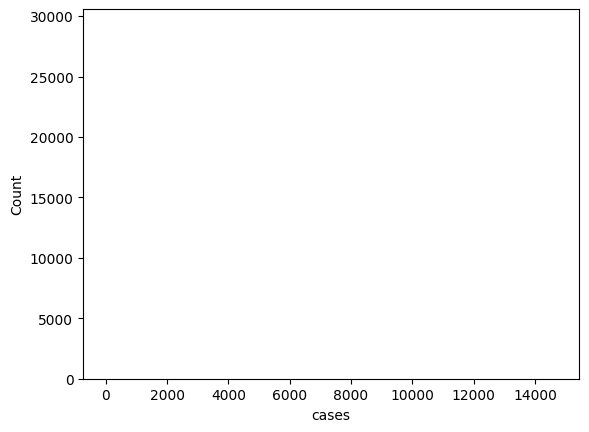

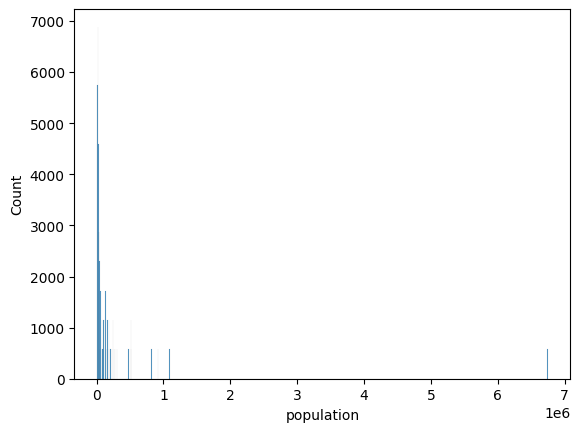

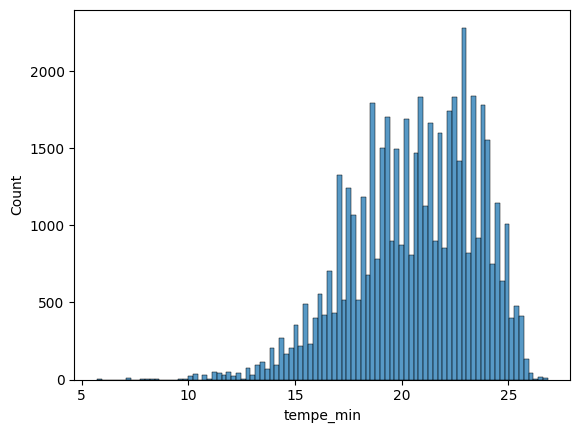

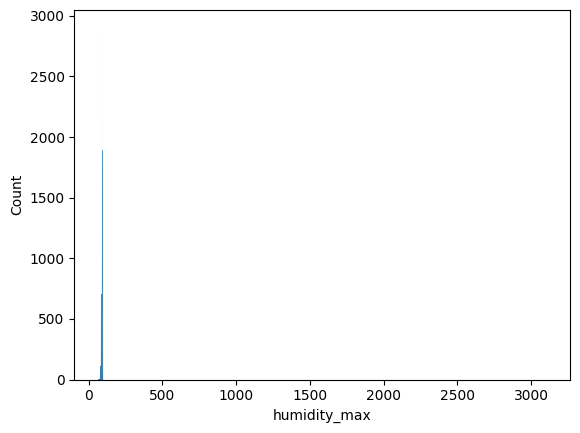

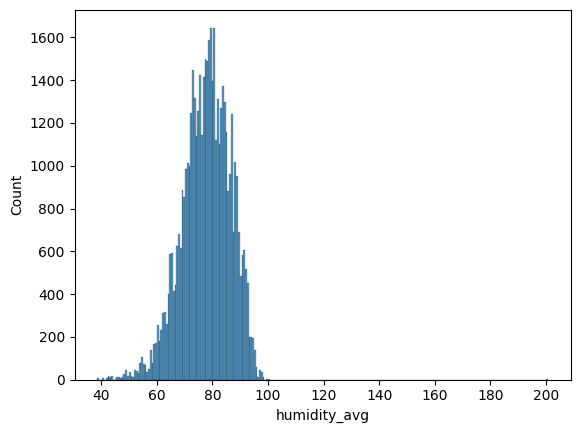

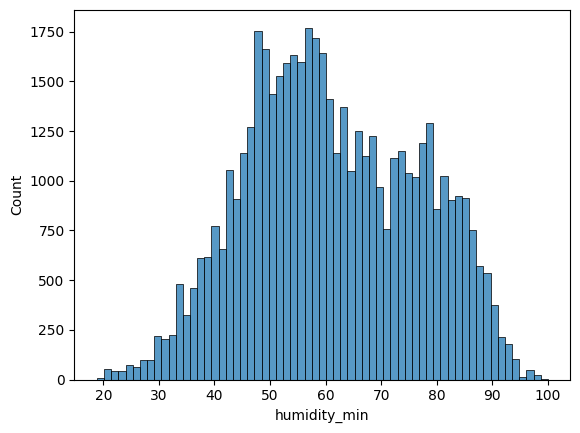

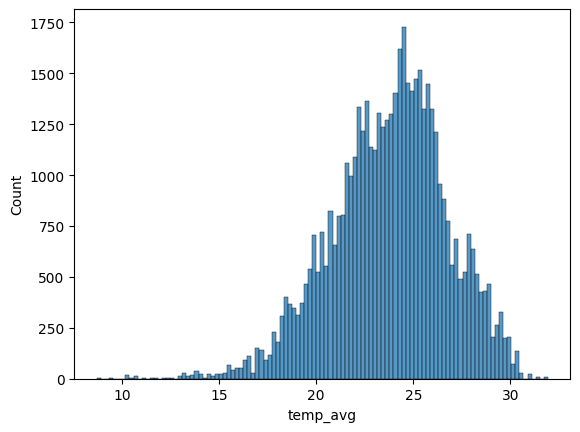

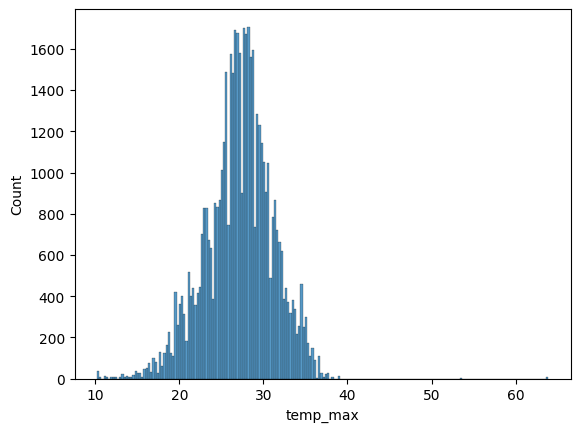

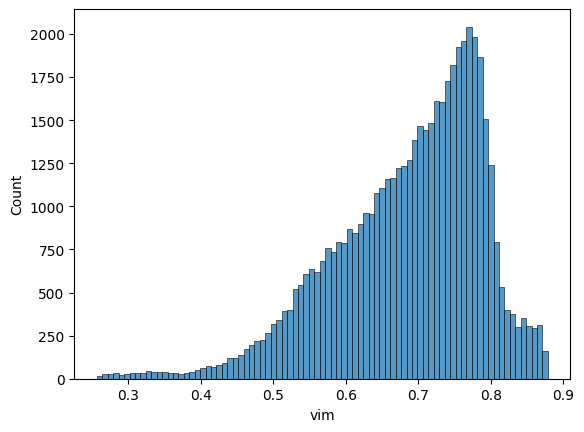

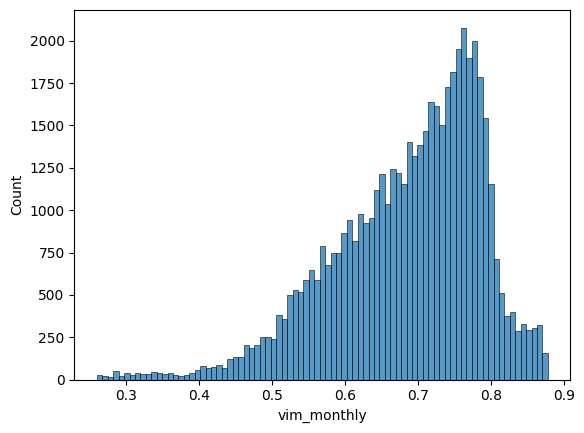

In [42]:
#histogram to understand the distribution
#understand the distribution normalizaton left skewed right skewed
for i in df.select_dtypes(include="number").columns:
    sns.histplot(data=df,x=i)
    plt.show()

What is a Boxplot?

A boxplot is a visual representation of the distribution of a dataset, highlighting:

Median: The line inside the box represents the median of the data.
Interquartile Range (IQR):The box spans from the 25th percentile (Q1) to the 75th percentile (Q3).
IQR = Q3 - Q1.
Whiskers:Extend to the smallest and largest values within 1.5 * IQR from Q1 and Q3, respectively.
Outliers: Data points beyond 1.5 * IQR from Q1 or Q3 are plotted as individual points and are considered potential outliers.

Why Use Boxplots?

Identify Outliers:The individual dots outside the whiskers represent potential outliers.

Understand Distribution:

Skewness in data can be observed:
Whiskers of unequal length indicate skewed data.
Compare Variability:
The size of the box reflects the variability in the data.

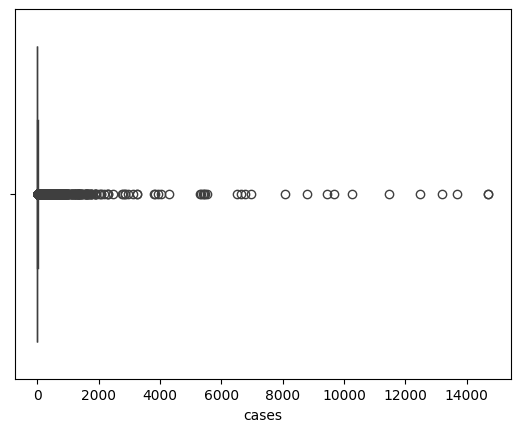

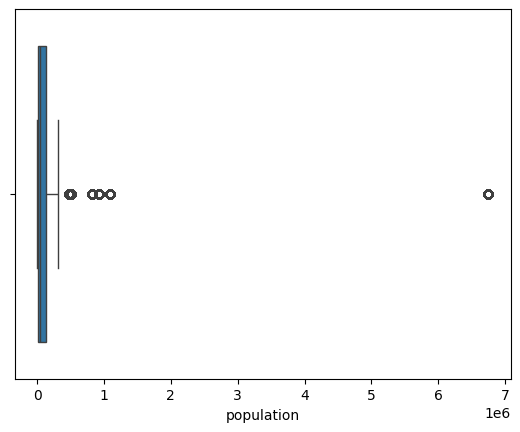

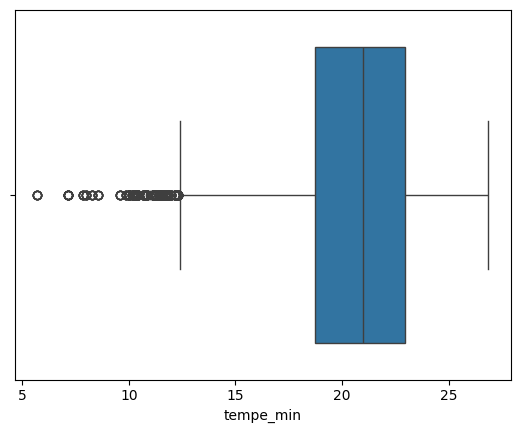

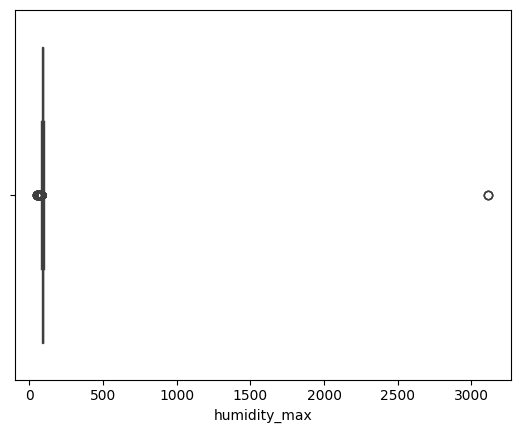

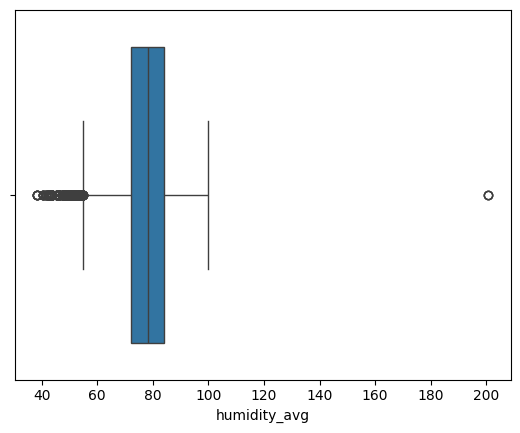

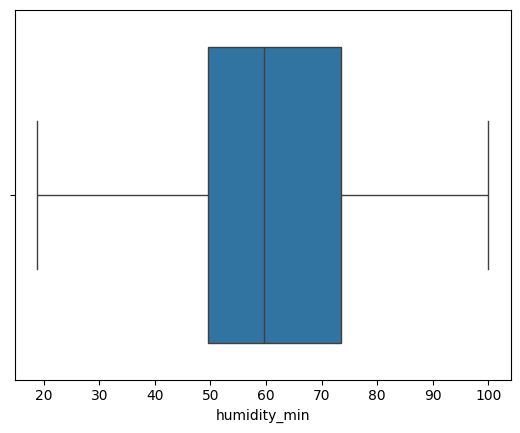

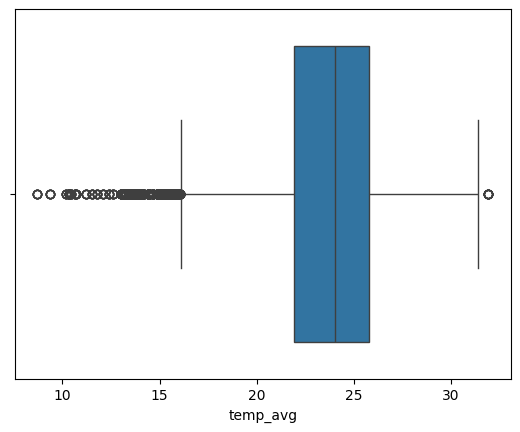

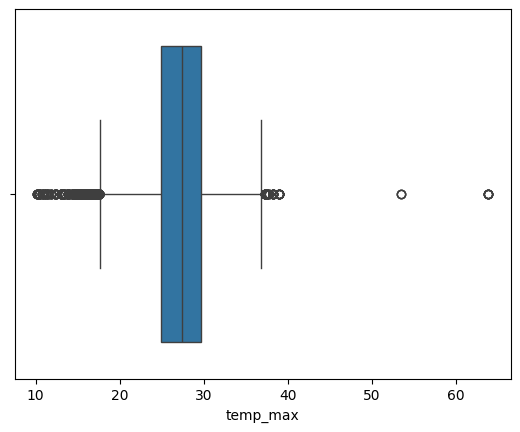

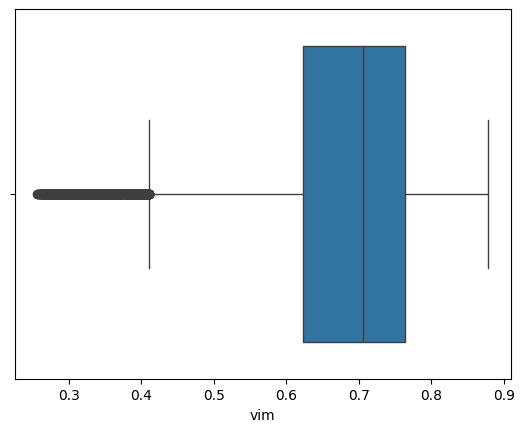

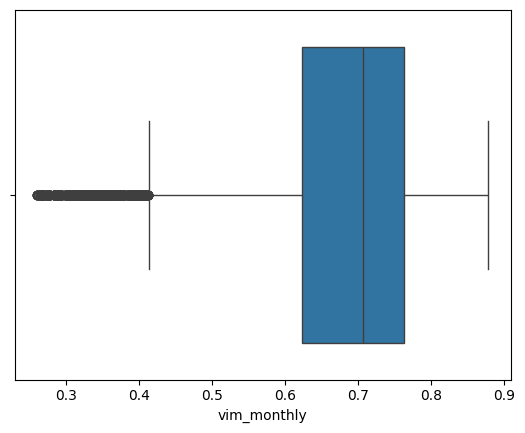

In [43]:
#boxflot to identify outliers
for i in df.select_dtypes(include="number").columns:
    sns.boxplot(data=df,x=i)
    plt.show()


Purpose of Scatter Plots in Data Analysis
Visualize Relationships:

Assess if there is a correlation between a feature and cases.
Positive correlation: As x increases, y increases.
Negative correlation: As x increases, y decreases.
No correlation: No clear trend between x and y.
Detect Patterns and Outliers:

Patterns like linear trends, clusters, or non-linear relationships can be observed.
Outliers appear as points far from the main cluster.
Feature Selection:

In [44]:
#inorder to build the model need to check whether there is a relationship between dependent var and independent var
#scatter plot to understand the relationship , positive negative likewise
df.select_dtypes(include="number").columns

Index(['cases', 'population', 'tempe_min', 'humidity_max', 'humidity_avg',
       'humidity_min', 'temp_avg', 'temp_max', 'vim', 'vim_monthly'],
      dtype='object')

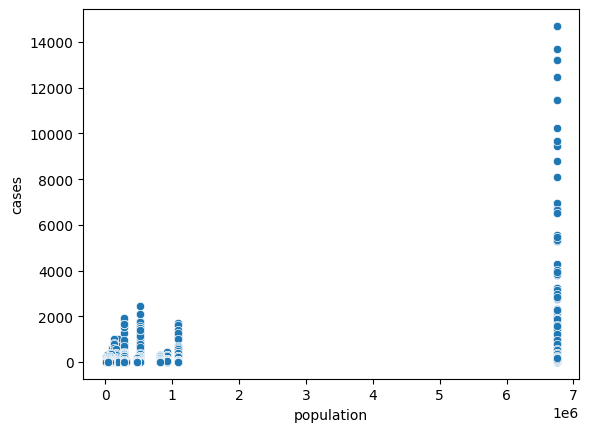

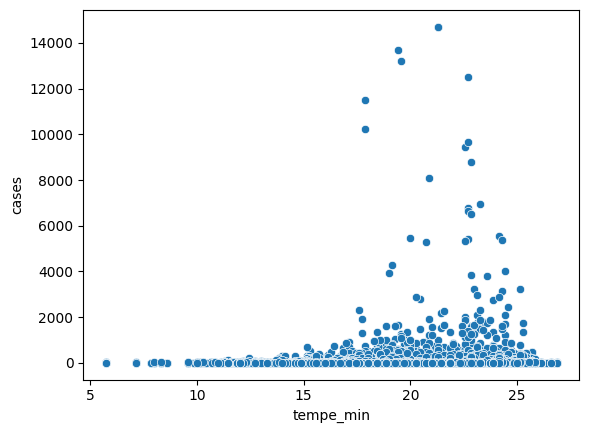

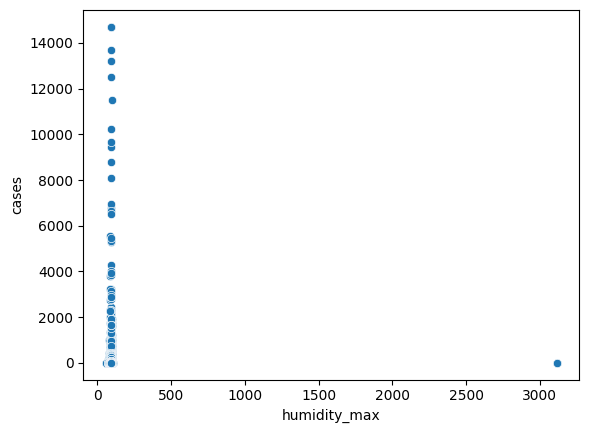

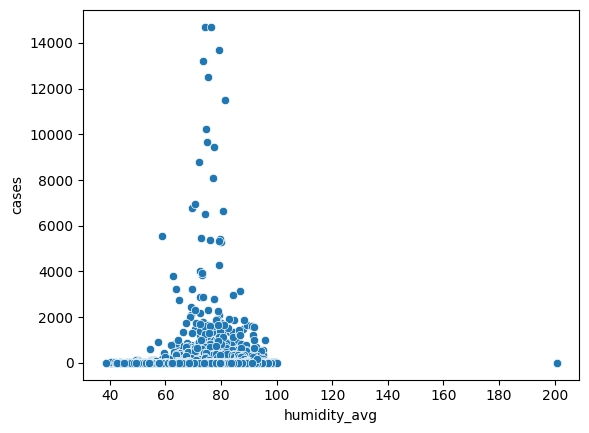

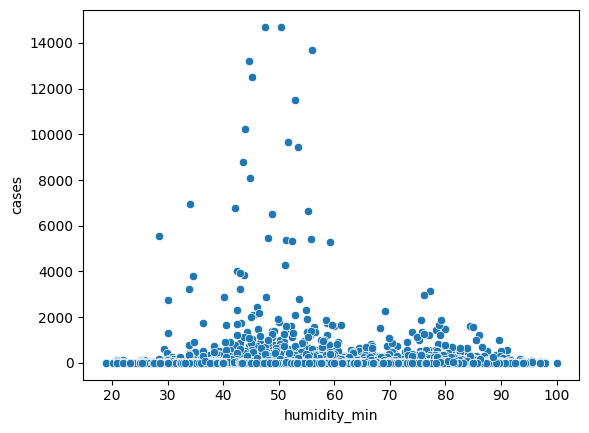

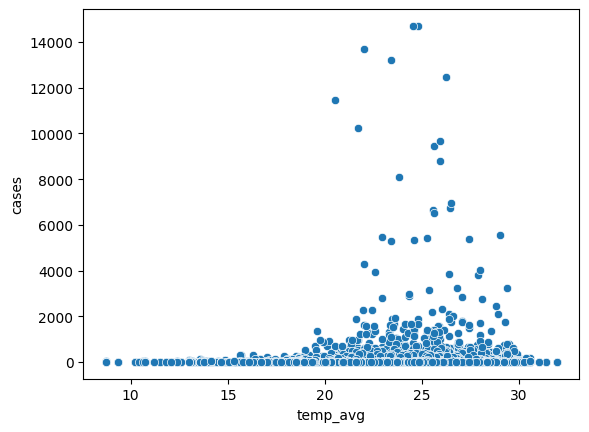

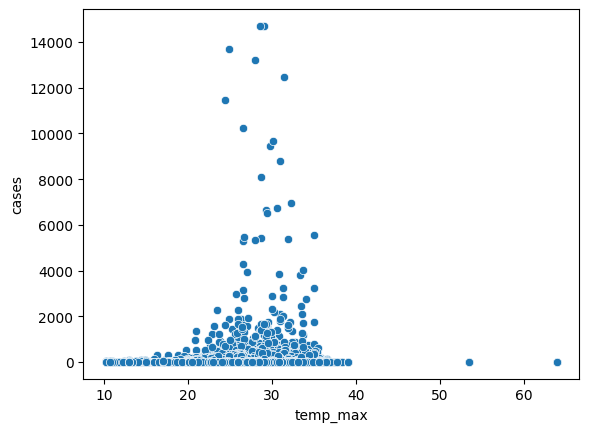

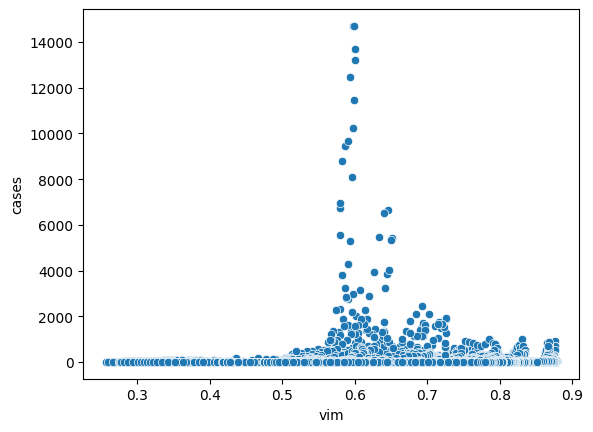

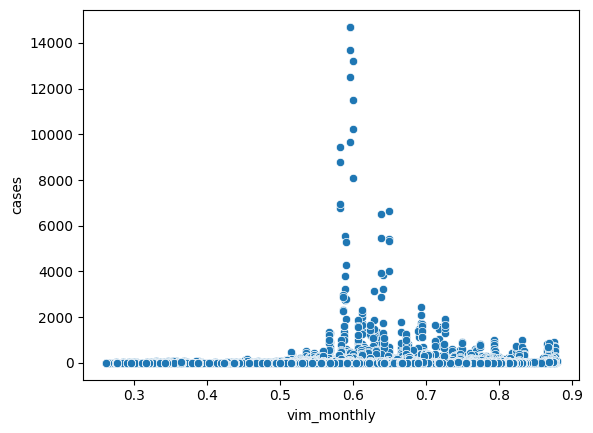

In [45]:
for i in ['population', 'tempe_min', 'humidity_max', 'humidity_avg',
       'humidity_min', 'temp_avg', 'temp_max', 'vim',
       'vim_monthly']:
    sns.scatterplot(data=df,x=i,y='cases')
    plt.show()

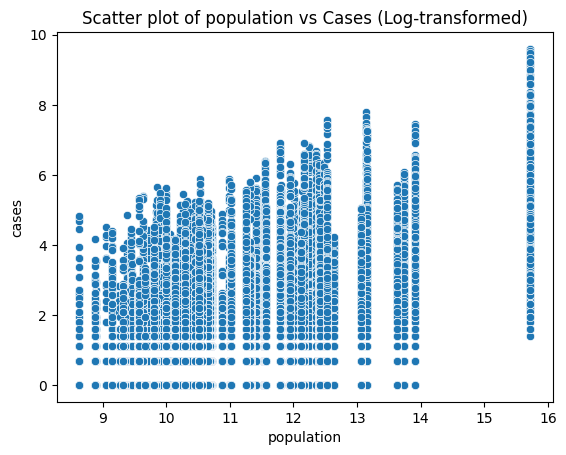

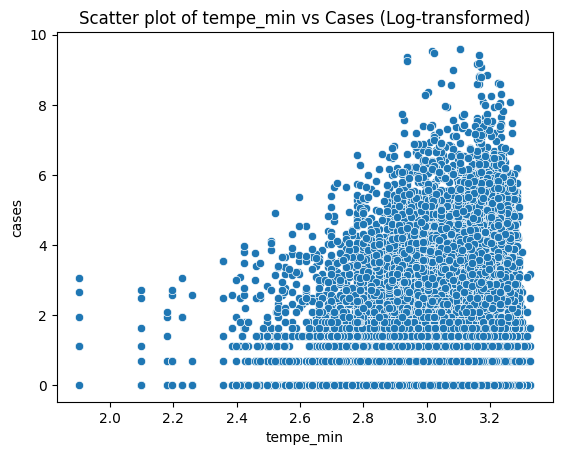

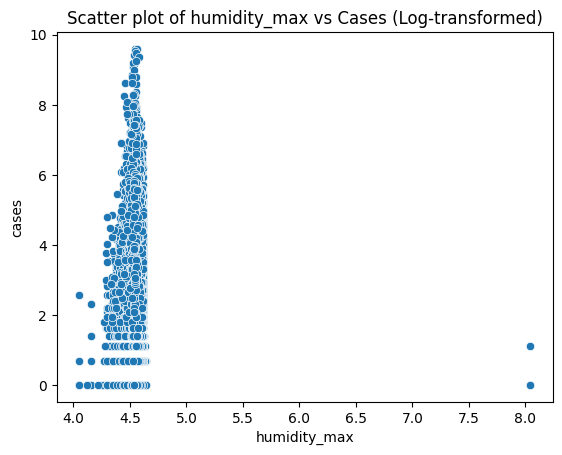

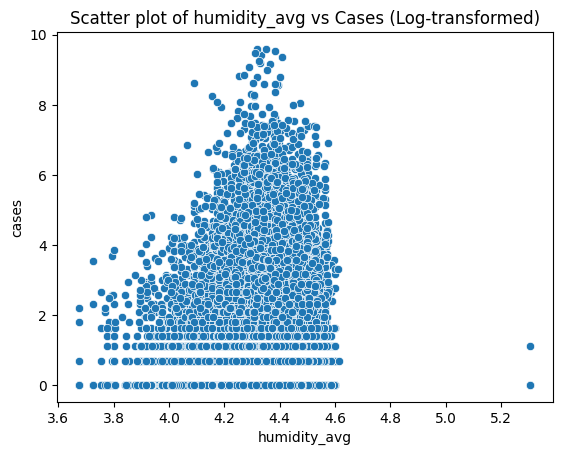

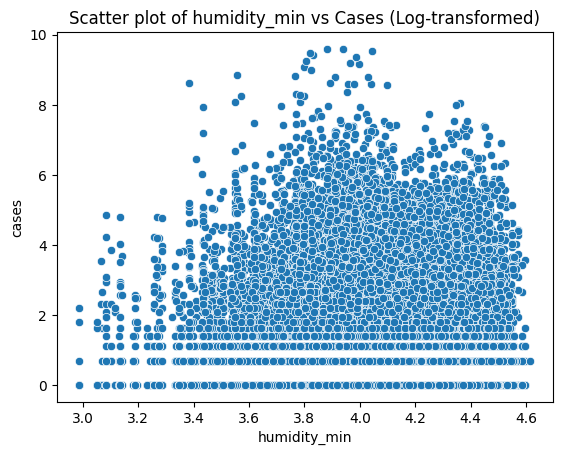

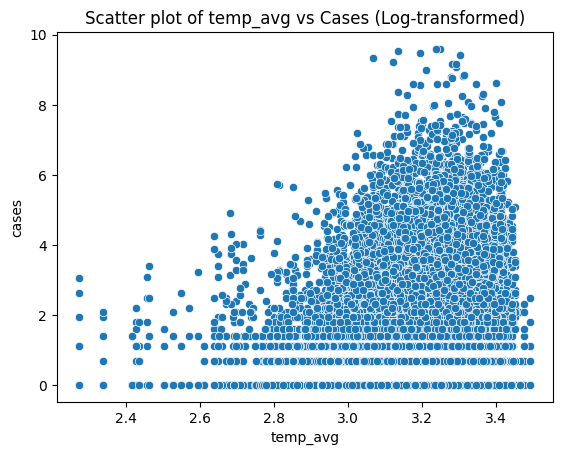

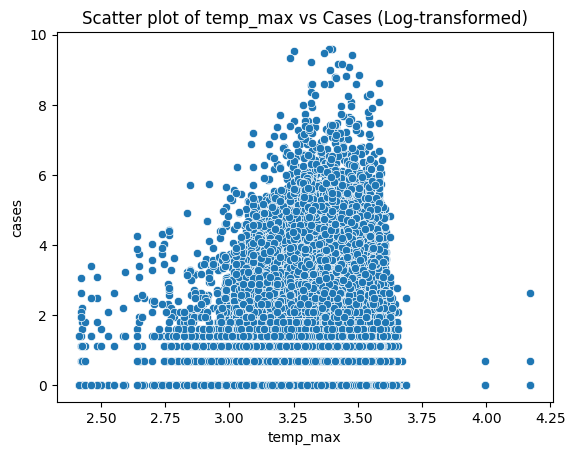

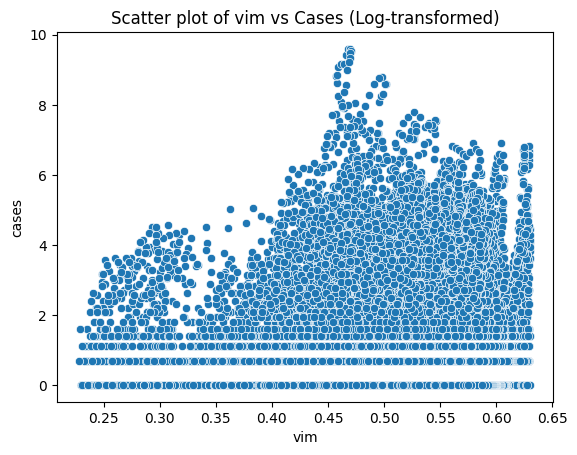

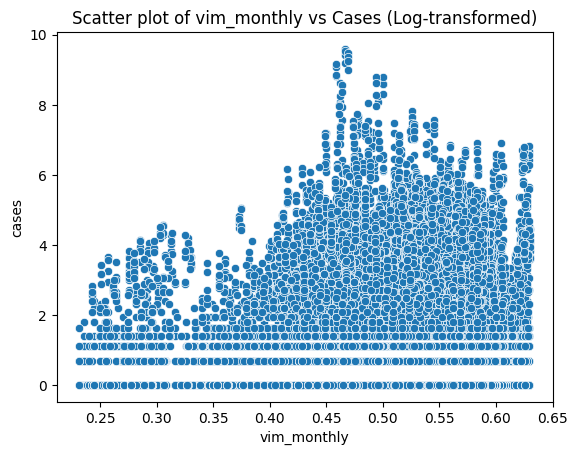

In [46]:
for i in ['population', 'tempe_min', 'humidity_max', 'humidity_avg',
           'humidity_min', 'temp_avg', 'temp_max', 'vim', 'vim_monthly']:
    sns.scatterplot(data=df, x=np.log1p(df[i]), y=np.log1p(df['cases']))  # Using log transformation
    plt.title(f'Scatter plot of {i} vs Cases (Log-transformed)')
    plt.show()


Purpose of Correlation Heatmaps
Understand Relationships:

Correlation values range from -1 to 1:
+1: Perfect positive correlation (both variables increase together).
-1: Perfect negative correlation (one variable decreases as the other increases).
0: No correlation.
Strong correlations (close to ±1) indicate a potential relationship between variables.
Detect Multicollinearity:

Multicollinearity occurs when two or more variables are highly correlated (e.g., correlation > 0.8 or < -0.8).
High multicollinearity can cause instability in regression models and affect feature importance in machine learning.
Feature Selection:

Identify redundant features (those with high correlations with other variables) and consider removing them to simplify your model.
How to Interpret the Heatmap
Diagonal Elements: Always 1, as a variable is perfectly correlated with itself.
Bright Colors: Indicate strong correlations.
Darker Colors: Indicate weaker correlations.
Clusters of High Correlation:
Variables in such clusters may contain redundant information.

<Axes: >

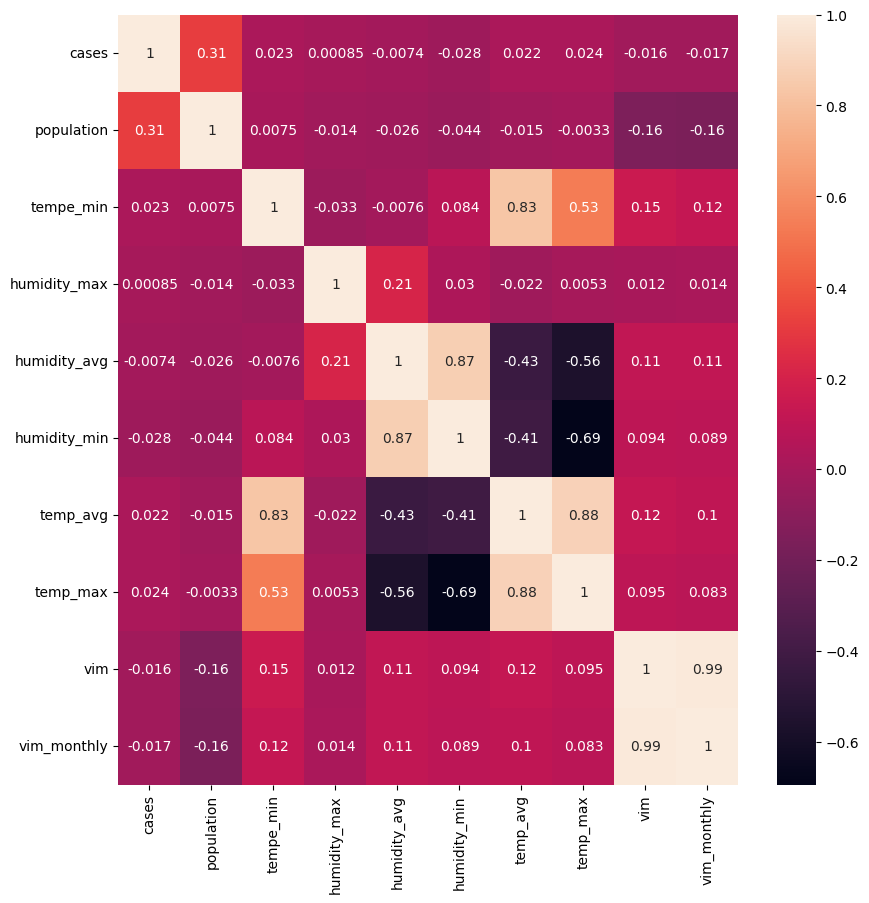

In [47]:
#correlation with heatmap to interpret the relationship and multicolliniarity
s = df.select_dtypes(include="number").corr()
plt.figure(figsize=(10,10))
sns.heatmap(s,annot=True)

Set a Correlation Threshold: Highlight only correlations above a certain threshold to focus on strong relationships:

<Axes: >

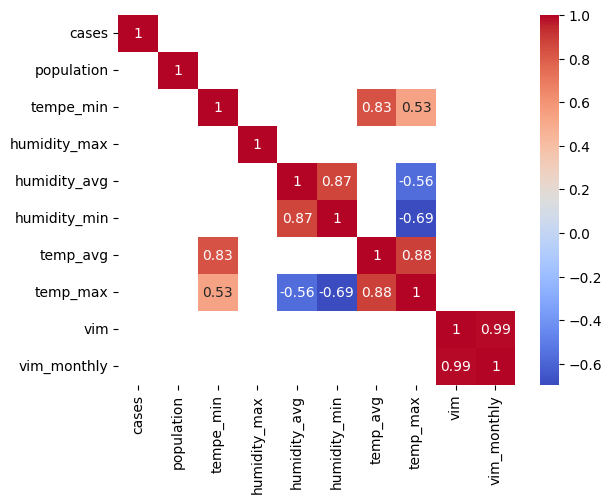

In [48]:
sns.heatmap(s, annot=True, mask=np.abs(s) < 0.5, cmap="coolwarm")


FILLING MISSING VALUES

In [49]:
df.isnull().sum()

date               0
week               0
cases              0
population         0
tempe_min          0
humidity_max    1957
humidity_avg    1957
humidity_min    1957
temp_avg        1957
temp_max        1957
city               0
geocode            0
vim                0
vim_monthly        0
dtype: int64

In [50]:
from sklearn.impute import KNNImputer

# Instantiate the imputer
imputer = KNNImputer()

# Apply imputation for numeric columns
for i in df.select_dtypes(include="number").columns:
    df[[i]] = imputer.fit_transform(df[[i]])

In [51]:
df.head(70)

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geocode,vim,vim_monthly
0,2012-01-01,201201,32.0,207044.0,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,Angra dos Reis,3300100,0.850500,0.852633
1,2012-01-08,201202,40.0,207044.0,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,Angra dos Reis,3300100,0.852050,0.852633
2,2012-01-15,201203,19.0,207044.0,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,Angra dos Reis,3300100,0.853541,0.852633
3,2012-01-22,201204,33.0,207044.0,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,Angra dos Reis,3300100,0.854877,0.852633
4,2012-01-29,201205,36.0,207044.0,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,Angra dos Reis,3300100,0.856021,0.852633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2013-03-31,201314,612.0,207044.0,20.285714,97.428571,76.640063,56.000000,24.900870,28.571429,Angra dos Reis,3300100,0.876090,0.875367
66,2013-04-07,201315,709.0,207044.0,20.142857,87.428571,73.522143,58.857143,23.513070,26.571429,Angra dos Reis,3300100,0.875956,0.875800
67,2013-04-14,201316,537.0,207044.0,15.285714,89.714286,68.131868,50.571429,20.725275,24.714286,Angra dos Reis,3300100,0.875715,0.875800
68,2013-04-21,201317,286.0,207044.0,14.000000,93.142857,63.929012,44.428571,20.488535,24.857143,Angra dos Reis,3300100,0.875220,0.875800
